### Part 1 - Exploratory data analysis

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,confusion_matrix,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import statsmodels.api as sm
import scipy.stats as stats

%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

In [26]:
with open('ultimate_challenge/logins.json', "r") as json_file:
    logins = json.load(json_file)

In [27]:
logins_df = pd.DataFrame(logins['login_time'], columns = ['login_time'])

In [28]:
logins_df.shape

(93142, 1)

In [29]:
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [30]:
logins_df.describe()

,login_time
count,93142
unique,92265
top,1970-03-17 01:01:39
freq,3


In [31]:
logins_df.dtypes

login_time    object
dtype: object

- turn column type into datetime

In [32]:
logins_df['login_time'] = pd.to_datetime(logins_df['login_time'])

In [33]:
logins_df.isna().sum()

login_time    0
dtype: int64

In [34]:
login_counts = logins_df.set_index('login_time')

- get log-in counts at 15 minutes interval

In [35]:
login_counts = login_counts.resample('15T').size().reset_index(name='login_count')

In [36]:
login_counts.head()

,login_time,login_count
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


In [37]:
login_counts.describe()

,login_count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


In [38]:
login_counts.dtypes

login_time     datetime64[ns]
login_count             int64
dtype: object

- extract year, month, day, time, and weekday

In [39]:
login_counts['year'] = login_counts['login_time'].dt.year
login_counts['month'] = login_counts['login_time'].dt.month
login_counts['day'] = login_counts['login_time'].dt.day
login_counts['time'] = login_counts['login_time'].dt.strftime('%H:%M')
login_counts['day of week'] = login_counts['login_time'].dt.day_name()

In [40]:
login_counts.dtypes

login_time     datetime64[ns]
login_count             int64
year                    int64
month                   int64
day                     int64
time                   object
day of week            object
dtype: object

In [41]:
login_counts.head()

,login_time,login_count,year,month,day,time,day of week
0,1970-01-01 20:00:00,2,1970,1,1,20:00,Thursday
1,1970-01-01 20:15:00,6,1970,1,1,20:15,Thursday
2,1970-01-01 20:30:00,9,1970,1,1,20:30,Thursday
3,1970-01-01 20:45:00,7,1970,1,1,20:45,Thursday
4,1970-01-01 21:00:00,1,1970,1,1,21:00,Thursday


In [42]:
login_counts.describe()

,login_count,year,month,day
count,9788.000000,9788.0,9788.000000,9788.000000
mean,9.515938,1970.0,2.259093,14.569268
std,8.328818,0.0,1.017219,8.683342
min,0.000000,1970.0,1.000000,1.000000
25%,3.000000,1970.0,1.000000,7.000000
50%,7.000000,1970.0,2.000000,14.000000
75%,13.000000,1970.0,3.000000,22.000000
max,73.000000,1970.0,4.000000,31.000000


From above, the data include log-ins from 1970.01 to 1970.04 
### **Data quality issue: 1970 is not reasonable as the log-in year in this context, so this data was recorded with mistake, likely the info of real start-time was missing so everything starts at in 1970 the default start time of all computer.**

- plot log-in counts per month

In [43]:
group_month = login_counts[['login_count', 'month']].groupby('month').sum()

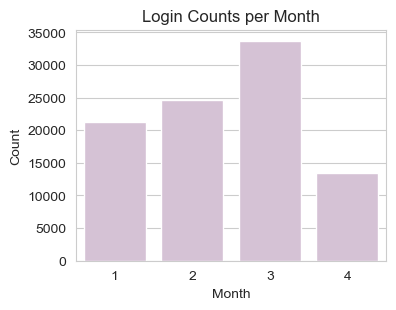

In [44]:
plt.subplots(figsize=(4,3))
sns.barplot(x=group_month.index, y=group_month['login_count'], color = 'thistle')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Login Counts per Month')
plt.show()

- plot the boxplot of daily log-ins acrossing four months

In [45]:
group_day = login_counts[['login_count', 'month', 'day']].groupby(['day','month'],as_index=False).sum()

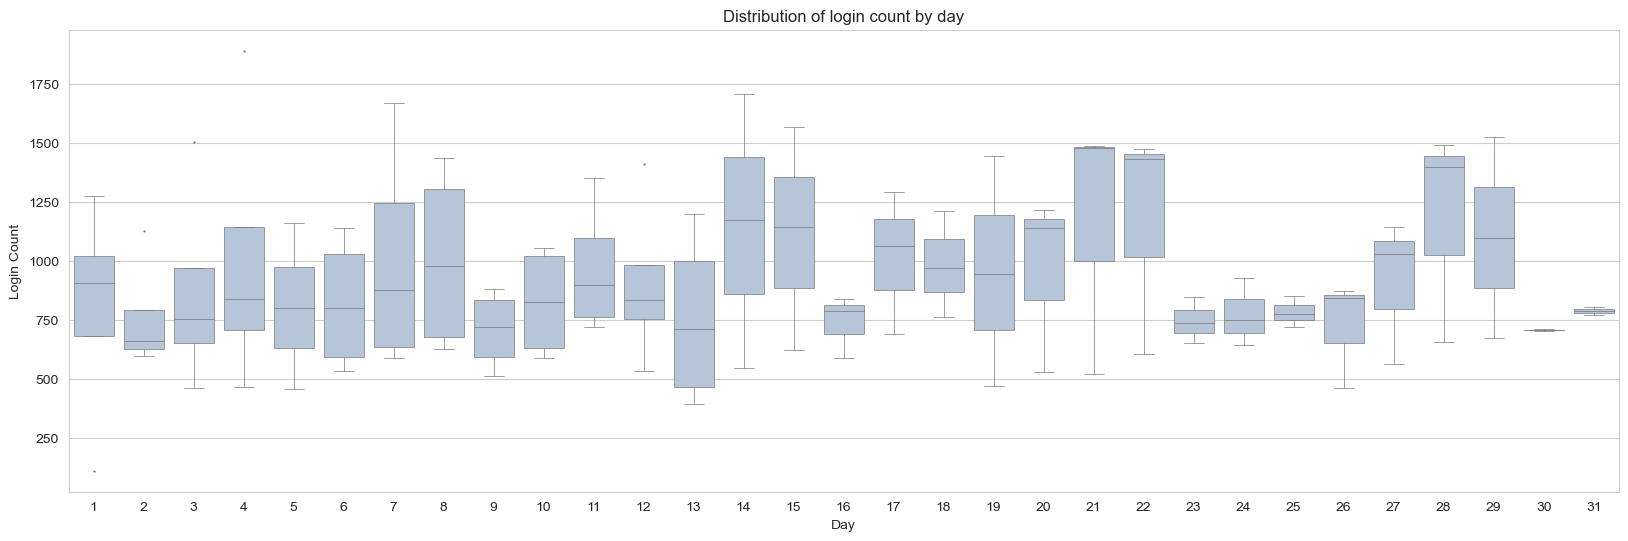

In [46]:
plt.subplots(figsize=(20,6))
sns.boxplot(x='day', y='login_count', data = group_day, color = 'lightsteelblue', fliersize =0.7, linewidth = 0.5)
plt.xlabel('Day')
plt.ylabel('Login Count')
plt.title('Distribution of login count by day') 
plt.show()

As the data only include four months, it's hard to make conclusion on this pattern here.

- plot the boxplot of log-ins by days of week acrossing four months

In [47]:
group_weekday = login_counts[['login_count', 'month', 'day', 'day of week']].groupby(['month', 'day', 'day of week'],as_index=False).sum()

In [48]:
group_weekday['day of week'].value_counts()

Thursday     15
Friday       15
Saturday     15
Sunday       15
Monday       15
Tuesday      14
Wednesday    14
Name: day of week, dtype: int64

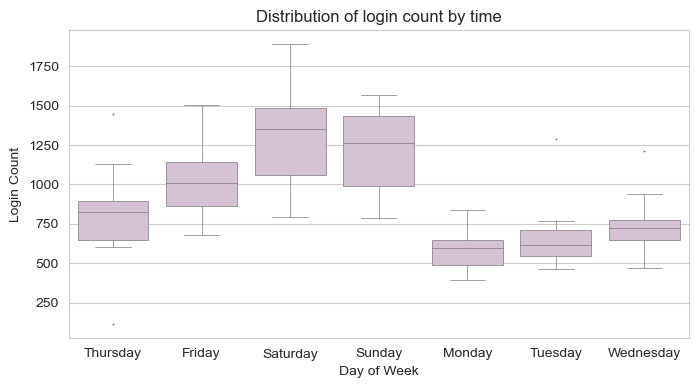

In [49]:
plt.subplots(figsize=(8,4))
sns.boxplot(x='day of week', y='login_count', data = group_weekday, color = 'thistle', fliersize =0.5, linewidth = 0.5)
plt.xlabel('Day of Week')
plt.ylabel('Login Count')
plt.title('Distribution of login count by time') 
plt.show()

As each category contains 14-15 values, we can say this boxplot shows patterns that Saturday has the most log-ins, Sunday and Friday have more than others. Monday has the least logins. Each category has 0-2 outliers.

- plot the boxplot of log-ins by time acrossing four months

In [50]:
login_counts['time'].value_counts()

20:00    102
10:45    102
13:00    102
12:45    102
12:30    102
        ... 
02:30    102
19:00    101
19:15    101
19:30    101
19:45    101
Name: time, Length: 96, dtype: int64

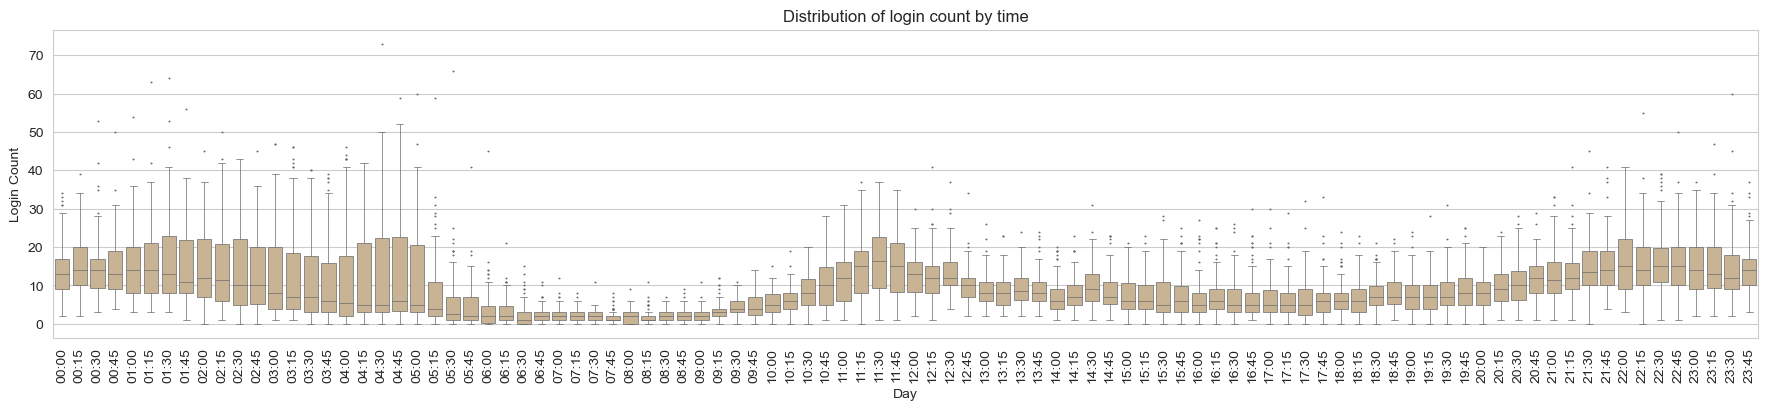

In [51]:
plt.subplots(figsize=(22,4))
sns.boxplot(x='time', y='login_count', data=login_counts.sort_values(by = 'time'),  color = 'tan', fliersize =0.5, linewidth = 0.5)
plt.xlabel('Day')
plt.ylabel('Login Count')
plt.title('Distribution of login count by time') 
plt.xticks(rotation=90)
plt.show()

As each category contains 101-102 values, we can say this boxplot shows patterns that the peak of log-in appear around 22:00 to 05:00, and the lowest log-in counts appear around 05:30 to 10:15. However, the spreading of value and outliers are prominent thus I'd like to separate them by days of week.

In [52]:
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

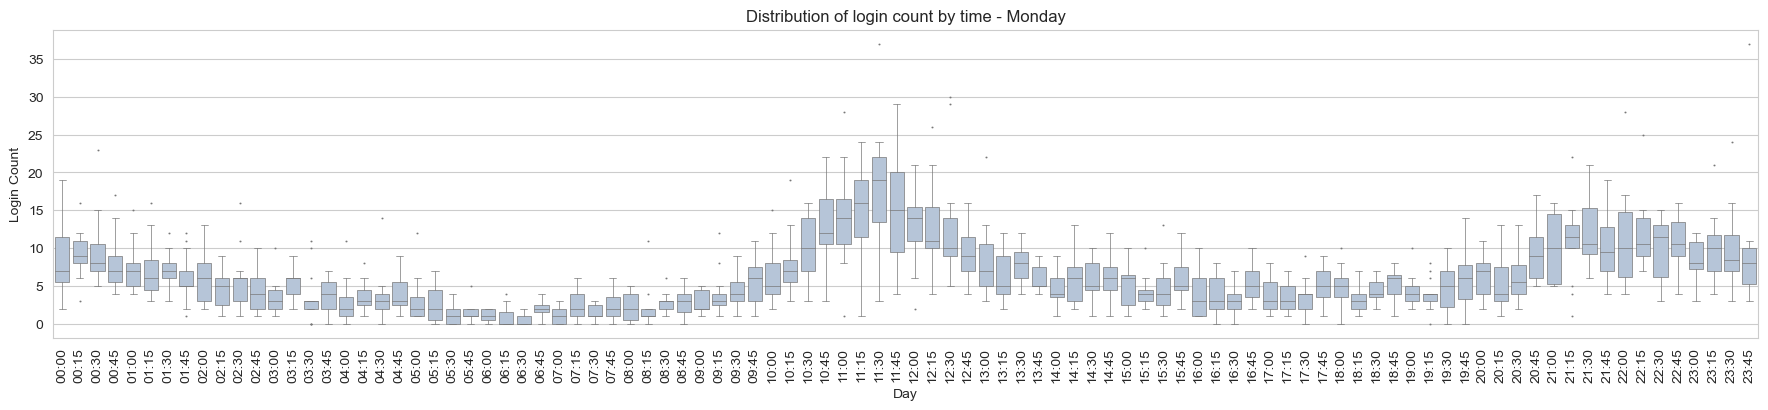

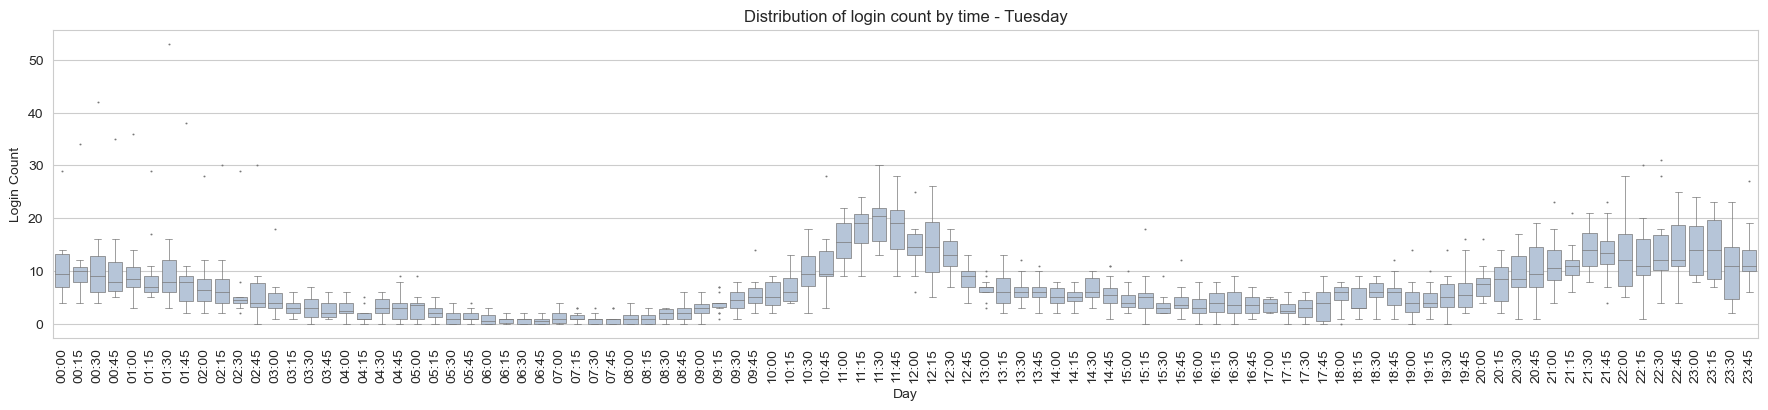

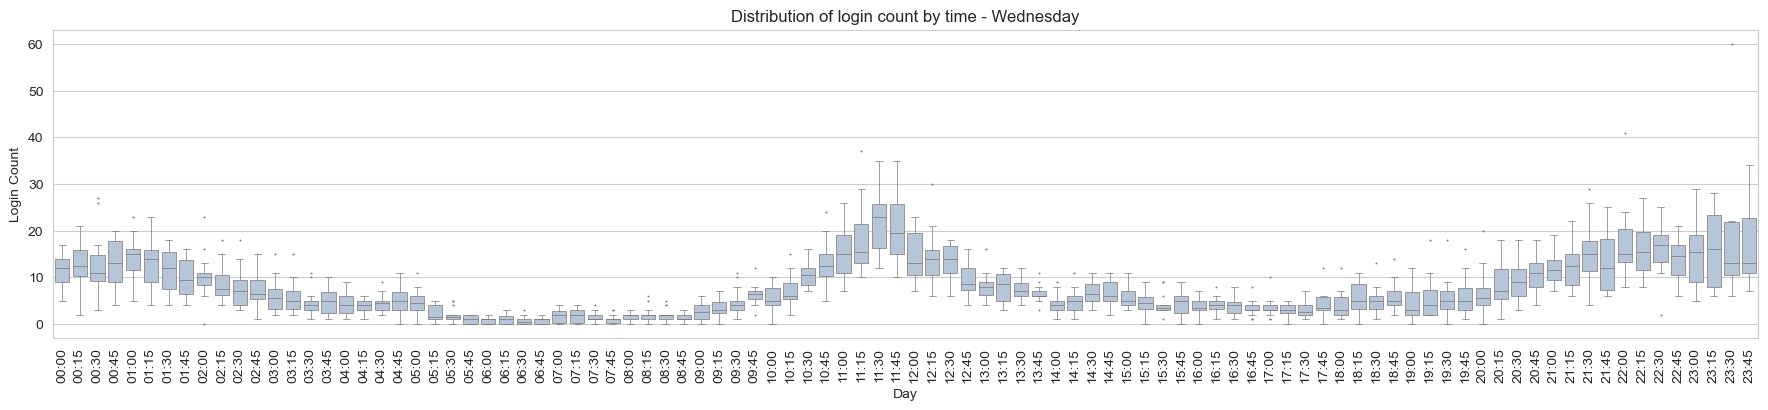

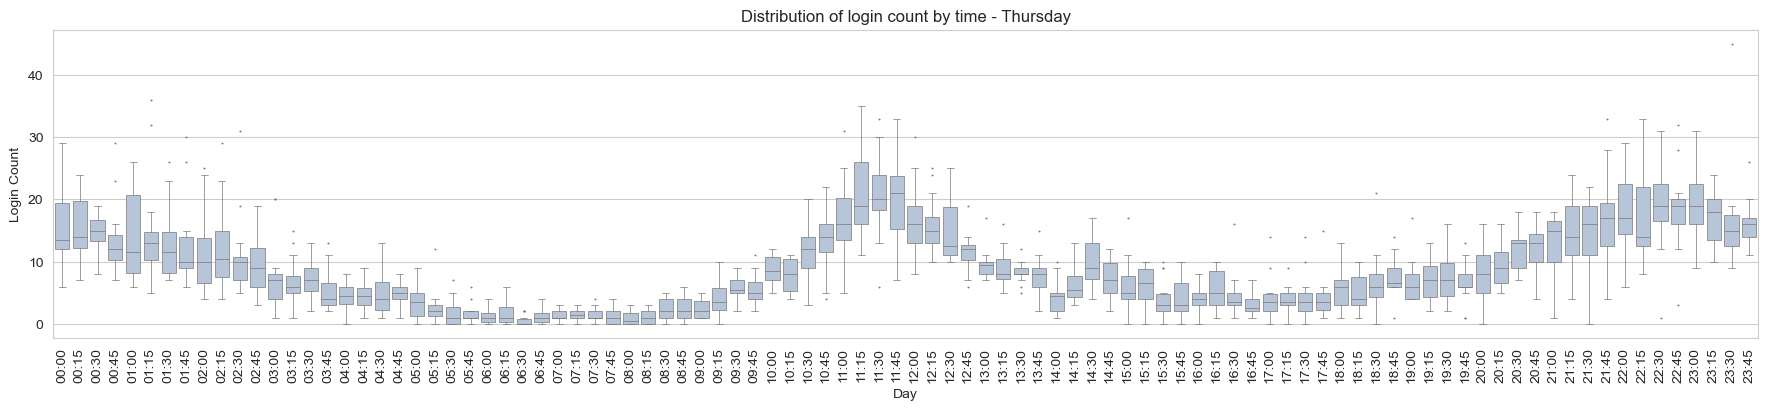

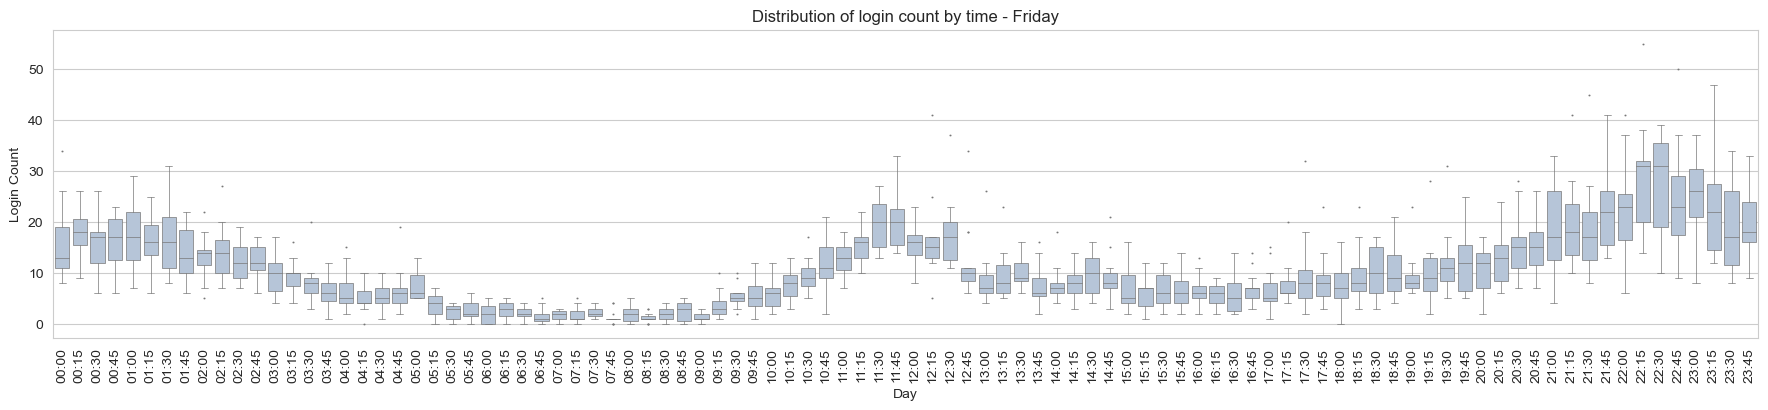

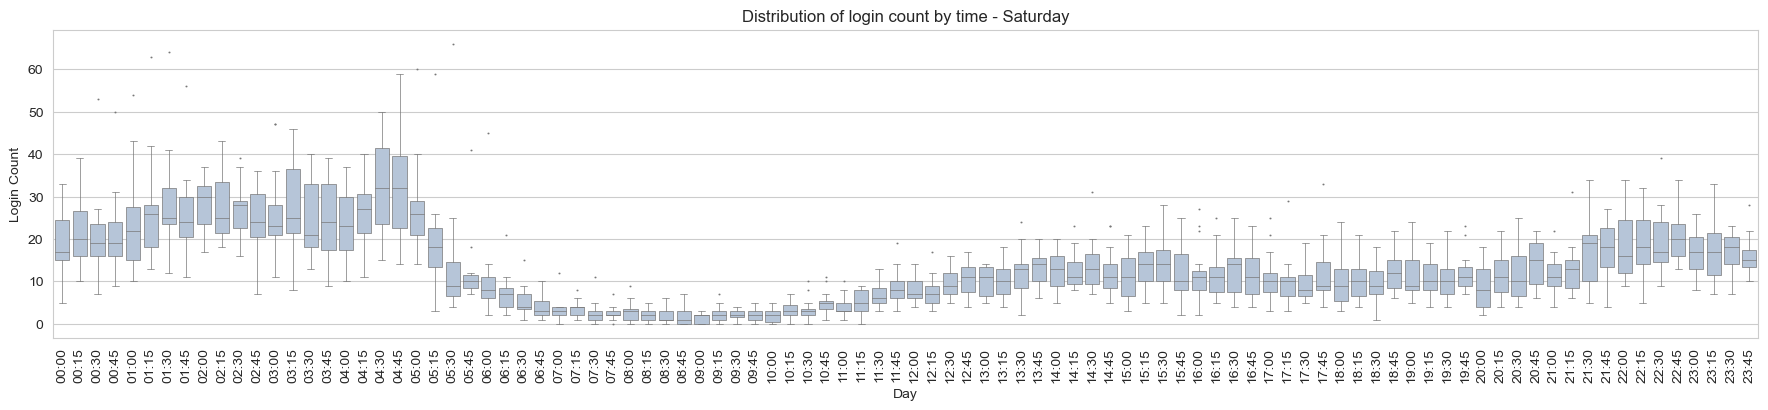

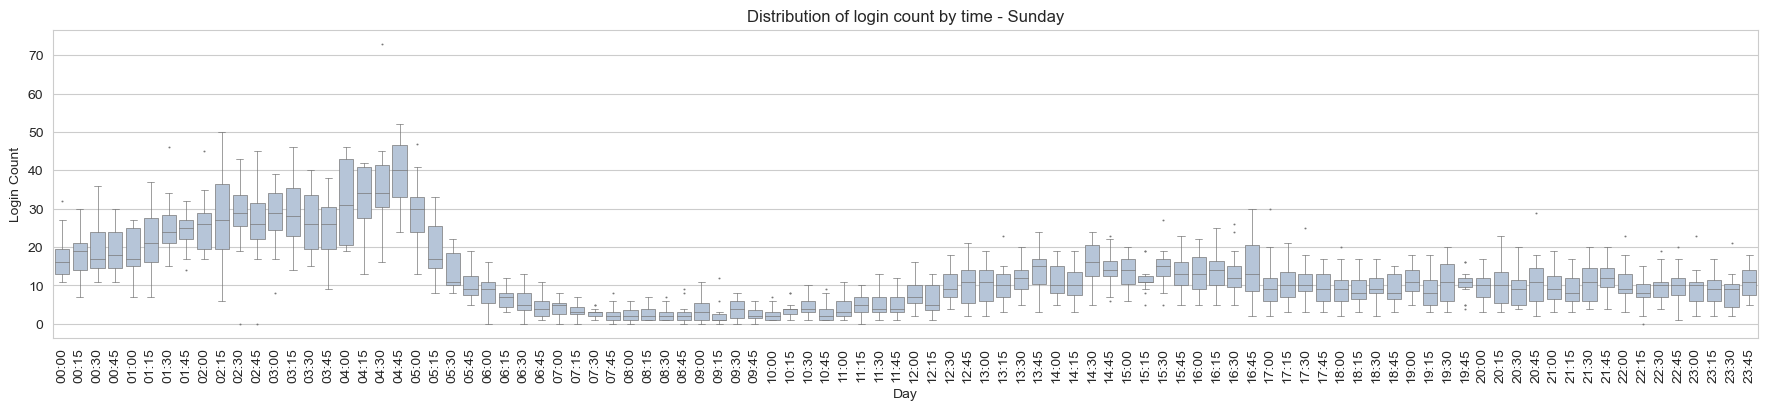

In [53]:
for day in day_names:
    plt.subplots(figsize=(22,4))
    sns.boxplot(x='time', y='login_count', data=login_counts[login_counts['day of week'] == day].sort_values(by = 'time'),  color = 'lightsteelblue', 
                fliersize =0.5, linewidth = 0.5)
    plt.xlabel('Day')
    plt.ylabel('Login Count')
    plt.title('Distribution of login count by time - '+str(day)) 
    plt.xticks(rotation=90)
    plt.show()

Now we can see that there are two levels of peak time. The Primary peak time appears during weekends: 22:00 Friday - 05:00 Saturday and 02:00 - 05:00 Sunday. The secondary peak time appears during weekdays at lunchtime: 10:30-12:30 each day.

### Part 2 - Experiment and metrics design

1) What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric? 

**A:** I will choose the waiting time of each service to measure the success of this experiment. Because the main purpose of this project to be provide enough drivers to the customers so they don't have to wait for a long time.


2) Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a) how you will implement the experiment

**A:** I will set a time period such as two months for the experiment, during which all toll costs will be reimbursed. I will record the waiting time of each services. If I have the data of waiting time before the experiment, I'll use two months of them as control group, otherwise I'll extend the experiment for two months without reimbusing and record the waiting time.

b) what statistical test(s) you will conduct to verify the significance of the
observation

**A:** Supposedly in this experiment I can retrieve data from all the services which is the whole population, thus I'll know the variance of the population. Therefore, I'll use paired t-test on each city's with/without reimbursement period. The hypothesis is there is no significant difference on waiting time with/without reimbursement.

c) how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

**A:** I'll choose the significant level at 0.05. If the resulted p-value is less than 0.05 for both cities, I reject the null hypothesis and suggest that reimbursing toll costs will encourage partners to be more available in both cities. If the resulted p-value is larger than 0.05 for both cities, I won't reject the null hypothesis and will suggest that reimbursing toll costs does not encourage partners to be more available in both cities. If the p-value is less than 0.05 for one city and larger than 0.05 for another, new experiments need to be added to draw conclusion.

### Part 3 - Predictive modeling

#### 1. Import json file and transform into dataframe

In [5]:
with open('ultimate_challenge/ultimate_data_challenge.json', "r") as json_file:
    challenge = json.load(json_file)

In [6]:
challenge_df = pd.DataFrame(challenge)

In [7]:
challenge_df.shape

(50000, 12)

In [8]:
challenge_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [9]:
challenge_df.columns

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver'],
      dtype='object')

In [10]:
challenge_df.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

#### 2. Create column 'active' to restore if each customer was active at their 6th month

In [11]:
challenge_df['signup_date'] = pd.to_datetime(challenge_df['signup_date'])

In [12]:
challenge_df['last_trip_date'] = pd.to_datetime(challenge_df['last_trip_date'])

In [13]:
challenge_df['6th_month'] = challenge_df['signup_date'] + pd.DateOffset(months = 5, days = 1)

In [14]:
challenge_df['threshold_day'] = challenge_df['6th_month'] - pd.DateOffset(days = 30)

In [15]:
challenge_df['active'] = challenge_df.apply(
    lambda row: 'Yes' if row['last_trip_date'] >= row['threshold_day'] else 'No', axis = 1)

In [16]:
model_df = challenge_df[['city', 'trips_in_first_30_days', 'avg_rating_of_driver',
       'avg_surge', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'active']]

In [17]:
model_df.shape

(50000, 11)

In [18]:
model_df['active'].value_counts()

No     27731
Yes    22269
Name: active, dtype: int64

The distribution of active state is not exactly even.

In [114]:
model_df.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,4.7,1.10,iPhone,15.4,True,46.2,3.67,5.0,Yes
1,Astapor,0,5.0,1.00,Android,0.0,False,50.0,8.26,5.0,No
2,Astapor,3,4.3,1.00,iPhone,0.0,False,100.0,0.77,5.0,No
3,King's Landing,9,4.6,1.14,iPhone,20.0,True,80.0,2.36,4.9,Yes
4,Winterfell,14,4.4,1.19,Android,11.8,False,82.4,3.13,4.9,No


In [115]:
model_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [116]:
model_df.isna().sum()

city                         0
trips_in_first_30_days       0
avg_rating_of_driver      8122
avg_surge                    0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
active                       0
dtype: int64

The column 'avg_rating_of_driver' has significant missing value, need to be explored for imputing decision.

In [117]:
model_df['avg_rating_of_driver'].value_counts()

5.0    20771
4.0     4193
4.5     2498
4.8     2430
4.7     1945
       ...  
1.7        2
1.8        2
1.9        1
1.6        1
2.2        1
Name: avg_rating_of_driver, Length: 37, dtype: int64

Most of the rating were distributed at higher ratings.

In [118]:
no_rating_of_driver = model_df[model_df['avg_rating_of_driver'].isna()]
no_rating_by_driver = model_df[model_df['avg_rating_by_driver'].isna()]

In [119]:
min_rating_of_driver = model_df[model_df['avg_rating_of_driver']==1.0]
min_rating_by_driver = model_df[model_df['avg_rating_by_driver']==1.0]

In [120]:
def get_active_ratio(df):
    print(df['active'].value_counts().index[0]+'/'+ df['active'].value_counts().index[1])
    print(df['active'].value_counts()[0]/df['active'].value_counts()[1])

In [121]:
get_active_ratio(no_rating_of_driver)

No/Yes
2.768909512761021


In [122]:
get_active_ratio(min_rating_of_driver)

No/Yes
2.878787878787879


In [123]:
get_active_ratio(no_rating_by_driver)

No/Yes
3.6744186046511627


In [124]:
get_active_ratio(min_rating_by_driver)

No/Yes
5.241379310344827


In [254]:
get_active_ratio(model_df)

No/Yes
1.2452736988638915


The customer who never rated driver resulted in similar non-active/active ratio with customer who rated driver at 1.0 (two
times of the total non-active/active ratio). The customer who was never rated by driver resulted in very different 
non- active/active ratio with customer was rated by driver at 1.0 (3.6 times of the total non-active/active ratio). 
Therefore, I'll fill the missing value of 'avg_rating_of_driver' with 0, and drop the row with missing value of 'avg_rating_by_driver'. As the number of missing value of 'phone' is relatively small, those rows are also dropped.

In [19]:
model_df['avg_rating_of_driver'] = model_df['avg_rating_of_driver'].fillna(0)

In [20]:
model_df = model_df.dropna(subset=['avg_rating_by_driver'])

In [21]:
model_df = model_df.dropna(subset=['phone'])

In [22]:
model_df.shape

(49406, 11)

In [23]:
model_df['city'].unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

In [24]:
model_df['phone'].unique()

array(['iPhone', 'Android'], dtype=object)

In [91]:
model_df.dtypes

city                       object
trips_in_first_30_days      int64
avg_rating_of_driver      float64
avg_surge                 float64
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
active                     object
dtype: object

#### 3. Explotary plotting

In [92]:
num_col = ['trips_in_first_30_days', 'avg_rating_of_driver',
       'avg_surge', 'surge_pct','weekday_pct', 'avg_dist',
       'avg_rating_by_driver']

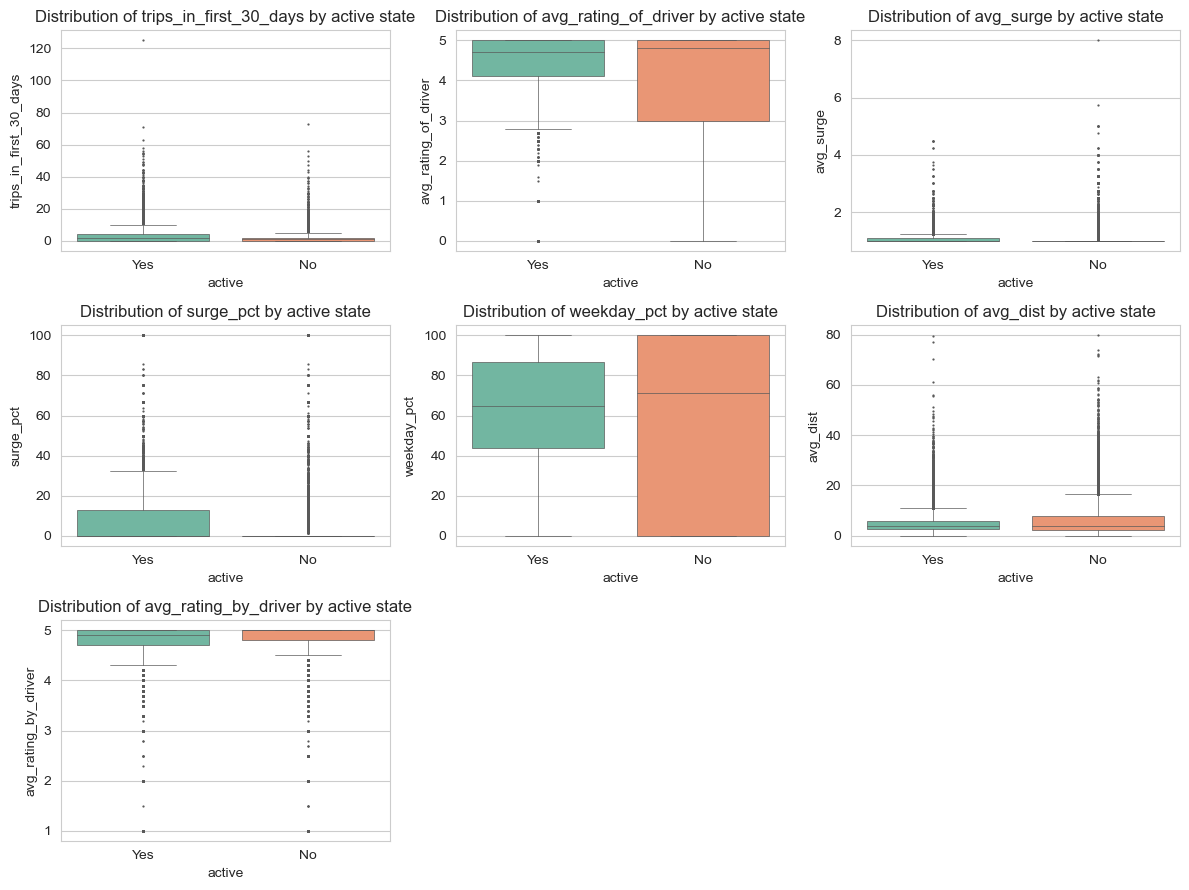

In [93]:
num_rows = (len(num_col) + 2) // 3

fig, axes = plt.subplots(num_rows, 3, figsize=(12, 3 * num_rows))

for idx, col in enumerate(num_col):
    row_idx = idx // 3
    col_idx = idx % 3
    sns.boxplot(x='active', y=col, data=model_df, palette='Set2', fliersize=0.7, linewidth=0.5, ax=axes[row_idx, col_idx])
    axes[row_idx, col_idx].set_xlabel('active')
    axes[row_idx, col_idx].set_ylabel(col)
    axes[row_idx, col_idx].set_title('Distribution of ' + col + ' by active state')

for idx in range(len(num_col), num_rows * 3):
    fig.delaxes(axes.flatten()[idx])

plt.tight_layout()
plt.show()

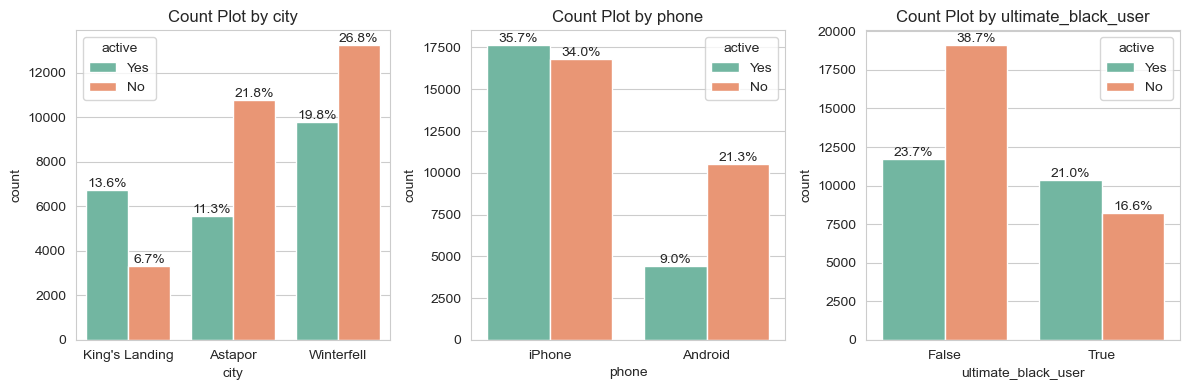

In [264]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
columns_to_plot = ['city', 'phone', 'ultimate_black_user']

for idx, col in enumerate(columns_to_plot):
    sns.countplot(x=col, hue='active', data=model_df, palette='Set2', ax=axes[idx])
    axes[idx].set_xlabel(col)
    axes[idx].set_title('Count Plot by ' + col)
    
    # Annotating with percentage
    total_count = len(model_df[col])
    for p in axes[idx].patches:
        height = p.get_height()
        percentage = f"{100 * height / total_count:.1f}%"
        axes[idx].annotate(percentage, (p.get_x() + p.get_width() / 2, height),
                           ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [26]:
model_df['city'] = model_df['city'].replace({"King's Landing":0, 'Astapor':1, 'Winterfell':2}) 
model_df['phone'] = model_df['phone'].replace({"iPhone":0, 'Android':1}) 
model_df['ultimate_black_user'] = model_df['ultimate_black_user'].replace({True:0, False:1}) 

In [40]:
X = model_df.drop(columns = ['active'])
y = model_df['active']

In [45]:
y = y.replace({'Yes':0, 'No':1}) 

In [29]:
merge = pd.concat([X, y], axis = 1)

In [105]:
merge.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,0,4,4.7,1.10,0,15.4,0,46.2,3.67,5.0,0
1,1,0,5.0,1.00,1,0.0,1,50.0,8.26,5.0,1
2,1,3,4.3,1.00,0,0.0,1,100.0,0.77,5.0,1
3,0,9,4.6,1.14,0,20.0,0,80.0,2.36,4.9,0
4,2,14,4.4,1.19,1,11.8,1,82.4,3.13,4.9,1


In [306]:
merge.shape

(49406, 11)

<Axes: >

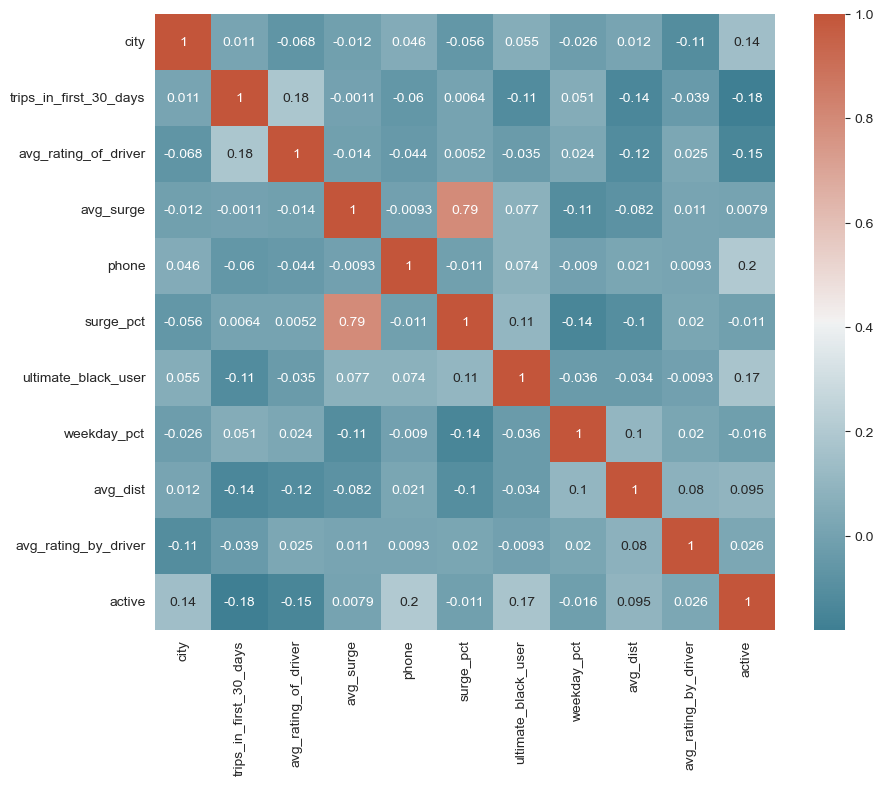

In [99]:
plt.subplots(figsize=(10,8))
sns.heatmap(merge.corr(),annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

- Use scipy.stats to get a quick insight of the logit classfication of the data

In [39]:
feature_names = X.columns

In [53]:
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
#X_scaled = pd.DataFrame(X_scaled, columns=feature_names)

In [57]:
feature_names

Index(['city', 'trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'phone', 'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver'],
      dtype='object')

In [54]:
log_reg = sm.Logit(y,X_scaled).fit()
print(log_reg.summary2())

Optimization terminated successfully.
         Current function value: 0.623394
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.093     
Dependent Variable: active           AIC:              61618.8108
Date:               2023-07-17 08:35 BIC:              61706.8890
No. Observations:   49406            Log-Likelihood:   -30799.   
Df Model:           9                LL-Null:          -33967.   
Df Residuals:       49396            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-------------------------------------------------------------------
       Coef.     Std.Err.      z       P>|z|     [0.025     0.975] 
-------------------------------------------------------------------
x1      0.6581     0.0243    27.0683   0.0000     0.6105     0.7058
x2    -11.9073     0.4193   -28.3957   0.0000   -12.7292  

From the plots and the classification insights above we can see that 'avg_surge' and 'surge_pct' have a high correlation and both have high p-value. I'll drop 'surge_pct' which has the higher p-value. Keep in record that 'avg_rating_by_driver' has a high p-value too.

In [59]:
model_df = model_df.drop(columns = 'surge_pct')

#### 4. Modeling

In [60]:
model_df['active'] = model_df['active'].astype('category')

In [134]:
lr_pipeline = Pipeline([('lr', LogisticRegression())])

rf_pipeline = Pipeline([('rf', RandomForestClassifier())])

knn_pipeline = Pipeline([('knn', KNeighborsClassifier())])

pipelines = [lr_pipeline, rf_pipeline, knn_pipeline]

In [141]:
def metrics_display(model, df):
    '''display model performence metrics'''
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='active'), 
                                                    df['active'], test_size=0.25, 
                                                    random_state=47)    
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    print(classification_report(y_test,y_pred))
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

    fig, ax = plt.subplots(figsize=(3, 3))  
    disp.plot(ax=ax)  
    plt.show()  

In [2]:
def modeling(df, scale = True):
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='active'), 
                                                    df['active'], test_size=0.25, 
                                                    random_state=47)
    if scale == True:
        scaler = MinMaxScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test= scaler.transform(X_test)
    else: pass
    
    highest_accuracy = 0.0
    best_pipeline = None

    for pipeline in pipelines:
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        model_name = pipeline.steps[-1][1].__class__.__name__
        print(f'{model_name} Accuracy: {accuracy:.2f}')

        if accuracy > highest_accuracy:
            highest_accuracy = accuracy
            best_pipeline = pipeline   
        else: pass
        
    print(' ')
    print('Best model: ' + best_pipeline.steps[-1][1].__class__.__name__)
    metrics_display(best_pipeline, df)

LogisticRegression Accuracy: 0.66
RandomForestClassifier Accuracy: 0.73
KNeighborsClassifier Accuracy: 0.72
 
Best model: RandomForestClassifier
              precision    recall  f1-score   support

          No       0.76      0.75      0.76      6835
         Yes       0.70      0.71      0.70      5517

    accuracy                           0.73     12352
   macro avg       0.73      0.73      0.73     12352
weighted avg       0.73      0.73      0.73     12352



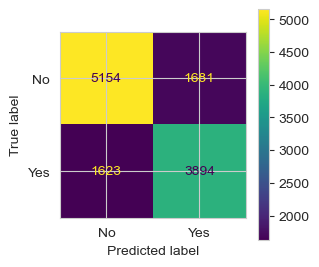

In [143]:
modeling(model_df)

LogisticRegression Accuracy: 0.66
RandomForestClassifier Accuracy: 0.73
KNeighborsClassifier Accuracy: 0.72
 
Best model: RandomForestClassifier
              precision    recall  f1-score   support

          No       0.76      0.75      0.76      6835
         Yes       0.70      0.71      0.70      5517

    accuracy                           0.73     12352
   macro avg       0.73      0.73      0.73     12352
weighted avg       0.73      0.73      0.73     12352



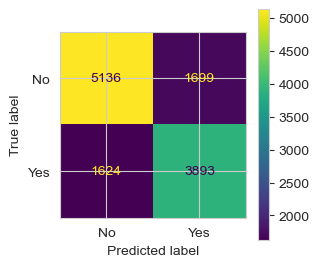

In [144]:
modeling(model_df, scale = False)

The best model is randomforest and scaling doesn't matter to the performance

- Drop the 'avg_rating_by_driver' to see if performance changes

In [145]:
model_df_2 = model_df.drop(columns = 'avg_rating_by_driver')

LogisticRegression Accuracy: 0.66
RandomForestClassifier Accuracy: 0.72
KNeighborsClassifier Accuracy: 0.72
 
Best model: RandomForestClassifier
              precision    recall  f1-score   support

          No       0.75      0.74      0.74      6835
         Yes       0.68      0.69      0.69      5517

    accuracy                           0.72     12352
   macro avg       0.71      0.72      0.72     12352
weighted avg       0.72      0.72      0.72     12352



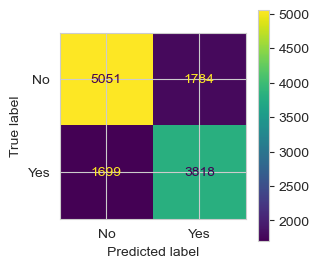

In [146]:
modeling(model_df_2)

The performance is worse than the first model, so 'avg_rating_by_driver' should stay

- Conduct Grid Search

In [61]:
X_train, X_test, y_train, y_test = train_test_split(model_df.drop(columns='active'), 
                                                model_df['active'], test_size=0.25, 
                                                random_state=47)

In [148]:
param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]}

In [150]:
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})

In [151]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
accuracy = best_model.score(X_test, y_test)
print("Best Model Accuracy:", accuracy)
print("Best Parameters: " + str(best_params))

Best Model Accuracy: 0.7597150259067358
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [152]:
feature_importances = best_model.feature_importances_

In [153]:
feature_importances

array([0.12339829, 0.11506867, 0.03900129, 0.1391115 , 0.05857166,
       0.0429674 , 0.1878425 , 0.07212492, 0.22191376])

                  Feature  Importance
0    avg_rating_by_driver    0.221914
1             weekday_pct    0.187843
2               avg_surge    0.139111
3                    city    0.123398
4  trips_in_first_30_days    0.115069
5                avg_dist    0.072125
6                   phone    0.058572
7     ultimate_black_user    0.042967
8    avg_rating_of_driver    0.039001


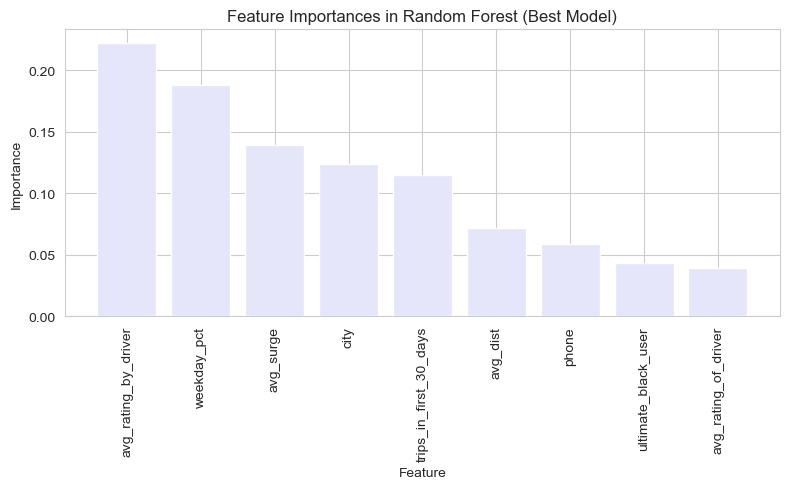

In [154]:
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
sorted_feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
sorted_feature_importance_df = sorted_feature_importance_df.reset_index(drop = True)
print(sorted_feature_importance_df)

plt.figure(figsize=(8, 5))
plt.bar(sorted_feature_importance_df['Feature'], sorted_feature_importance_df['Importance'], color = 'lavender')
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances in Random Forest (Best Model)')
plt.tight_layout()
plt.show()

In [74]:
log_reg = sm.Logit(y_train,X_scaled).fit()
print(log_reg.summary2())

Optimization terminated successfully.
         Current function value: 0.623113
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.094     
Dependent Variable: active           AIC:              46195.6263
Date:               2023-07-17 08:46 BIC:              46272.3075
No. Observations:   37054            Log-Likelihood:   -23089.   
Df Model:           8                LL-Null:          -25476.   
Df Residuals:       37045            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
x1        0.6867     0.0280    24.4929   0.0000    0.6318    0.7417
x2       -6.7246     0.2742   -24.5249   0.0000   -7.2620 

In [160]:
log_reg = sm.Logit(y,model_df[['avg_rating_by_driver', 'weekday_pct', 'avg_surge', 'trips_in_first_30_days']]).fit()
print(log_reg.summary2())

Optimization terminated successfully.
         Current function value: 0.668803
         Iterations 5
                            Results: Logit
Model:                Logit              Pseudo R-squared:   0.027     
Dependent Variable:   active             AIC:                66093.7217
Date:                 2023-07-17 01:43   BIC:                66128.9530
No. Observations:     49406              Log-Likelihood:     -33043.   
Df Model:             3                  LL-Null:            -33967.   
Df Residuals:         49402              LLR p-value:        0.0000    
Converged:            1.0000             Scale:              1.0000    
No. Iterations:       5.0000                                           
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
avg_rating_by_driver    0.0886   0.0095   9.3612 0.0000  0.0700

**Conclusion** The final model has an accuracy score at 0.76. Among all the features, 'avg_rating_by_driver', 'weekday_pct', 'avg_surge', 'city', 'trips_in_first_30_days' have importance over 1.0, with 'avg_rating_by_driver' on the top (importance 2.2). Therefore, I will recommend the company to explore methods to encourage the drivers to rate customer higher, improve either 'avg_surge' or'surge_pct' as they are correlated, and look into the potential reason certain city has a lower six months active rate.